In [1]:
import numpy as np
from h5py import File
import matplotlib.pyplot as plt
import dask.array as da
import fish_proc.wholeBrainDask.cellProcessing_single_WS as fwc
import os

In [2]:
dir_ = '/nrs/ahrens/jing/state_modulation/MG_vs_replayGU/20201101/fish02/9dpf_HuC-GC6F_MG-vs-ReplayGU_fish02_exp02_20201101_214112/im_CM0-voluseg/'
save_root = '/nrs/ahrens/jing/state_modulation/MG_vs_replayGU/20201101/fish02/9dpf_HuC-GC6F_MG-vs-ReplayGU_fish02_exp02_20201101_214112/im_CM0-voluseg/'
if not os.path.exists(save_root):
    os.makedirs(save_root)

In [4]:
cell_file = File(dir_+'cells0_clean.hdf5', 'r')
volume_file = File(dir_+'volume0.hdf5', 'r')
# timeseries_file = File(dir_+'mean_timeseries.hdf5', 'r')

In [6]:
background = cell_file['background'][()]
background

102.9773432360447

In [7]:
X=cell_file['cell_x']
Y=cell_file['cell_y']
Z=cell_file['cell_z']
W=cell_file['cell_weights'][()]
V=cell_file['volume_weight']

In [8]:
F = cell_file['cell_timeseries_raw'][()]
background = cell_file['background'][()]
brain_map=volume_file['volume_mean'][()]

CPU times: user 2min 27s, sys: 5.08 ms, total: 2min 27s
Wall time: 2min 27s


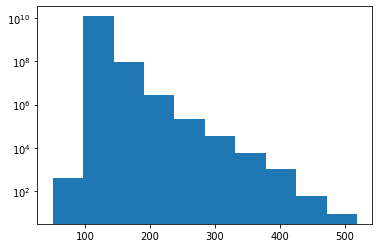

In [9]:
%%time
plt.figure()
plt.hist(np.ravel(F))
plt.yscale('log')

In [16]:
%%time
# remove background from raw F
F = F - (background - 10)
F[F<0]=0
F_dask = da.from_array(F, chunks=('auto', -1))
win_ = 400
baseline_ = da.map_blocks(fwc.baseline, F_dask, dtype='float', window=win_, percentile=20, downsample=10).compute(scheduler="processes")
dFF = F/baseline_-1

## 4min 50s

CPU times: user 2min 34s, sys: 2min 40s, total: 5min 15s
Wall time: 4min 50s


### brain map

In [21]:
np.save(save_root+'Y_ave.npy', brain_map)

In [18]:
## Check dFF
np.isnan(dFF).sum(), (dFF==np.inf).sum()

(0, 0)

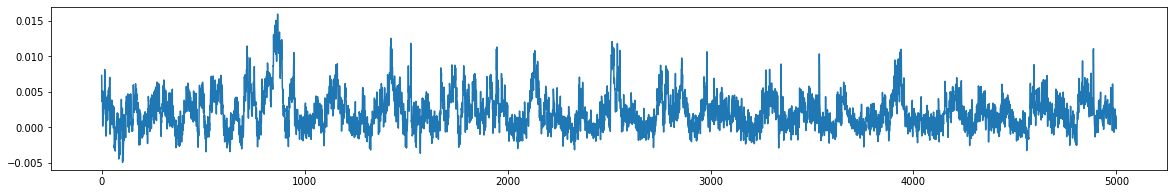

In [19]:
plt.figure(figsize=(20, 3))
plt.plot(dFF[51413][:5000])

### Cell locations

In [22]:
F = cell_file['cell_timeseries_raw']

In [23]:
def cell_loc(cell_id):
    thres_ = 0.005
    w_ = (W[cell_id]>thres_)*W[cell_id]
    w_[np.isnan(w_)]=0
    x_loc, y_loc, z_loc = X[cell_id],Y[cell_id],Z[cell_id]
    return (z_loc.dot(w_))/w_.sum(), (x_loc.dot(w_))/w_.sum(), (y_loc.dot(w_))/w_.sum()

In [24]:
numCells = F.shape[0]
A_center = np.zeros((numCells,3))
for n_cell in range(numCells):
    A_center[n_cell] = cell_loc(n_cell)
np.save(save_root+'cell_center.npy', A_center)

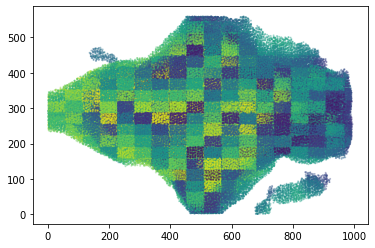

In [25]:
plt.scatter(A_center[:,1], A_center[:,2], c=A_center[:,0], s=1, alpha=0.3)

### Put cell weights on the brain grids

In [26]:
brain_shape = V.shape

In [27]:
func_map = np.zeros(brain_shape)
numCells = F.shape[0]
for cell_id in range(numCells):
    thres_ = 0.005
    w_ = (W[cell_id]>thres_)*W[cell_id]
    w_[np.isnan(w_)]=0
    x_loc, y_loc, z_loc = X[cell_id],Y[cell_id],Z[cell_id]
    func_map[x_loc, y_loc, z_loc]=np.maximum(func_map[x_loc,y_loc,z_loc], w_)

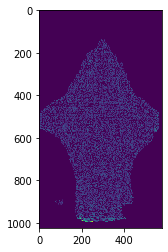

In [28]:
plt.imshow(func_map[:, :, 10])
plt.show()

### Put cell ids on the brain grids

In [29]:
func_map = np.zeros(brain_shape)-1
numCells = F.shape[0]
for cell_id in range(numCells):
    w_ = W[cell_id].copy()
    w_[np.isnan(w_)]=0
    thres_ = np.max(w_)*0.2 # 0.005
    w_[w_<thres_]=0
    x_loc, y_loc, z_loc = X[cell_id][w_>0],Y[cell_id][w_>0],Z[cell_id][w_>0]
    func_map[x_loc, y_loc, z_loc]=cell_id%16

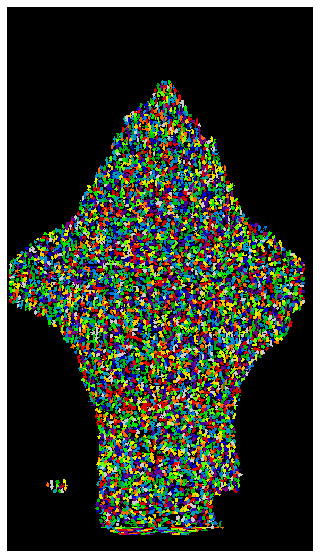

In [30]:
plt.figure(figsize=(8, 10))
plt.imshow(func_map[:, :, 10], cmap=plt.cm.nipy_spectral)
plt.axis('off')
plt.show()

In [31]:
np.savez(save_root+'cell_dff.npz', \
         dFF=dFF.astype('float16'), \
         brain_shape=brain_shape, \
         X=X, Y=Y, Z=Z, W=W)

In [32]:
X=cell_file['cell_x']
Y=cell_file['cell_y']
Z=cell_file['cell_z']
W=cell_file['cell_weights'][()]